# Deep Learning Computer Vision Experiments

These Jupyter Notebooks are a walkthrough tutorial to Deep Learning Computer Vision application using the library [fastai v2](https://github.com/fastai/fastai2) which builds on [PyTorch](https://pytorch.org/).

For each of the applications artificial data generators are used. This eliminates the need for external data sets and facilitates scalability explorations.

## Image Classification

*Image Classification* is the task of assigning a category label to an image. Given are photographs of objects in which there is one prominent object shown around the center of the image. Typically, this object is also the largest object in the image (excluding backgroud structures such as sky).

Let's create an artificial data set containing [numerical digits](https://en.wikipedia.org/wiki/Numerical_digit) as the primary object in each image. However, you can also skip this notebook and use the [saved images](https://github.com/j-k/deep_vision_fastai_v2/tree/master/00_classifier_images) in this repository with the [next notebook](https://github.com/j-k/deep_vision_fastai_v2/blob/master/01_image_classification.ipynb) in which a Deep Learning classifier is trained.

To make this experiment a little bit more interesting numerical digits are drawn from random fonts and corrupted with the data augmentation pipline [imgaug](https://imgaug.readthedocs.io/en/latest/).

### Important imports

First, install all Python packages such that the following code section runs through smoothly.

In [2]:
%matplotlib inline
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
import random
import string

### Experiments to get a random digit image

#### Create a black single layer PIL image

In [3]:
im_size = 64
image = Image.new('L', (im_size, im_size), 0)

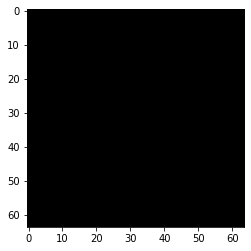

In [5]:
plt.imshow(np.asarray(image), cmap='gray')

#### Load system fonts

In [13]:
# enter your font path here
#path_fonts = Path(r"C:\Windows\Fonts")
path_fonts = Path(r"/usr/share/fonts/truetype")

In [14]:
fonts = list(path_fonts.rglob("*.ttf"))

In [15]:
len(fonts)

286

In [16]:
fonts[0:5]

[PosixPath('/usr/share/fonts/truetype/Gargi/Gargi.ttf'),
 PosixPath('/usr/share/fonts/truetype/padauk/Padauk-Regular.ttf'),
 PosixPath('/usr/share/fonts/truetype/padauk/PadaukBook-Bold.ttf'),
 PosixPath('/usr/share/fonts/truetype/padauk/PadaukBook-Regular.ttf'),
 PosixPath('/usr/share/fonts/truetype/padauk/Padauk-Bold.ttf')]

#### Construct a loop to make a print fit to the image

The following code to fit the digit's size to the image is heavily inspired from [here](https://stackoverflow.com/questions/4902198/pil-how-to-scale-text-size-in-relation-to-the-size-of-the-image.) 

In [17]:
font_height = 0
margin = 10
font = ImageFont.truetype(str(fonts[1]), font_height)
while font.getsize("1")[1] < im_size-margin:
    font = ImageFont.truetype(str(fonts[1]), font_height)
    font_height += 1
font_height

55

In [18]:
ImageDraw.Draw(image).text((0, 0), "1", font=font, fill=255)

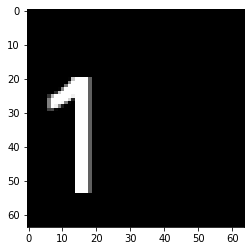

In [19]:
plt.imshow(np.asarray(image), cmap='gray')

### Definition of a random image generation function

Now, we can put all insights together and construct a function that prints single random digits in an image with varying print and background brightness. 

In [20]:
def get_random_digit_image(fonts, im_size, margin, bg_max, fg_min):
    img = Image.new('L', (im_size, im_size), random.randrange(0, bg_max))
    digit = str(random.randrange(0, 10))
    font_height = 0
    idx = random.randrange(0, len(fonts))
    font = ImageFont.truetype(str(fonts[idx]), 0)
    while font.getsize(digit)[1] < im_size-2*margin:
        font = ImageFont.truetype(str(fonts[idx]), font_height)
        font_height += 1
    font = ImageFont.truetype(str(fonts[idx]), font_height-1)
    font_size = font.getsize(digit)
    ImageDraw.Draw(img).text(
        ((im_size-font_size[0])/2, (im_size-font_size[1])/2),
        digit,
        font=font,
        fill=random.randrange(fg_min, 255)
    )
    return img, digit

In [21]:
image, d = get_random_digit_image(fonts, im_size, margin, 100, 105)

'0'

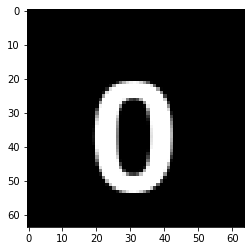

In [23]:
plt.imshow(np.asarray(image), cmap='gray'); d

In [15]:
d

'2'

### Definition of a data augmentation pipeline based on [imgaug](https://imgaug.readthedocs.io/en/latest/)
Data augmentation pipeline stolen from [here](https://imgaug.readthedocs.io/en/latest/source/examples_basics.html#a-standard-use-case) and tamed (set to be less corruptive). 

In [26]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    sometimes(iaa.Crop(percent=(0, 0.1))),
    sometimes(iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-15, 15),
        shear=(-16, 16),
        order=[0, 1],
        cval=(0, 255),
        mode=ia.ALL
    )),
    iaa.SomeOf((1, 4), [
        iaa.OneOf([
            iaa.GaussianBlur((0, 3.0)),
            iaa.AverageBlur(k=(2, 7)),
            iaa.MedianBlur(k=(3, 11)),
        ]),
        iaa.AdditiveGaussianNoise(
            loc=0, scale=(0.0, 0.05*255), per_channel=0.5
        ),
        sometimes(
            iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
        ),
        sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.15)))
    ], random_order=True)
], random_order=True)

### Generating and saving images

In the final step images are produced and saved. There are already images contained in this repository. However, by running this section you can increase the number of the images used for training and testing (see [next notebook](https://github.com/j-k/deep_vision_fastai_v2/blob/master/01_image_classification.ipynb)).

To remove all new images type `git clean -f`. In case images get overwritten do not commit.

In [27]:
all_images_and_idxs = [
    get_random_digit_image(fonts, im_size, margin, 100, 105)
        for i in range(200)
]

In [28]:
all_images_np = [np.asarray(im[0]) for im in all_images_and_idxs]

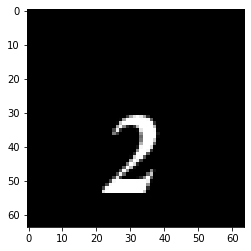

In [29]:
plt.imshow(all_images_np[42], cmap='gray')

In [30]:
images_aug = seq(images=all_images_np)

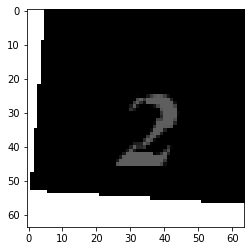

In [31]:
plt.imshow(images_aug[42], cmap='gray')

In [32]:
all_idxs = [im[1] for im in all_images_and_idxs]

In [33]:
all_idxs[0:10]

['8', '6', '3', '1', '6', '8', '2', '3', '6', '7']

In [34]:
#https://stackoverflow.com/questions/2257441/random-string-generation-with-upper-case-letters-and-digits
def random_string(length=5):
  return ''.join(
      random.sample(string.ascii_lowercase, length)
  )
random_string()

'gjady'

In [35]:
# %mkdir 00_classifier_images
# -> folder exists already

In [36]:
for k in range(len(all_idxs)):
    im = Image.fromarray(all_images_np[k])
    im.save("00_classifier_images/"+all_idxs[k]+"_"+random_string()+".jpeg")

End of `00_classifier_images_generation.ipynb`